#Aircraft Detection
##1.C51/1.C01 Final Project
###Darsh Grewal, Alvin Chen

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]
        self.img_dir = img_dir
        self.transform = transform or transforms.Compose([
            transforms.ToTensor()  # Convert images to PyTorch tensors
        ])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        #full image path
        img_name = os.path.join(self.img_dir, self.img_files[idx])
        image = Image.open(img_name).convert('RGB')  # Convert image to RGB

        #converting to tensor
        image = self.transform(image)

        #Extract label from filename
        label = int(self.img_files[idx].split('_')[0])  # Label is the first part before the first underscore
        return image, label

#dataset compiled
img_dir = '/content/drive/MyDrive/1.CX1 Project (1)/planesnet/planesnet'
dataset = CustomImageDataset(img_dir=img_dir)

# Split into 80% training, 20% validation
train_size = int(0.8 * len(dataset))
val_size = int(0.2 * len(dataset))
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders for training and validation
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


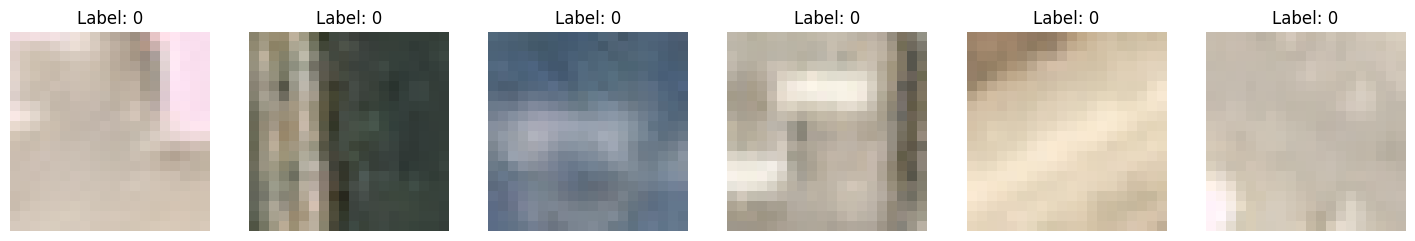

In [ ]:
#testing if the data is loading, print random images

def show_images(data_loader):
    # Create an iterator from the data_loader
    dataiter = iter(data_loader)
    images, labels = next(dataiter)  # Get one batch of images and labels

    # Setup plot
    fig, axes = plt.subplots(1, 6, figsize=(6 * 3, 3))

    for i in range(6):
        ax = axes[i]
        # Convert the PIL image to NumPy array and then display
        ax.imshow(images[i].numpy().transpose(1, 2, 0))
        ax.axis('off')  # Hide axes ticks
        ax.set_title(f"Label: {labels[i]}")

    plt.show()

#shwoing random images from train_loader
show_images(train_loader)

In [ ]:
#CNN architecture

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # 3 input channels (RGB), 16 output channels, kernel size 3
            nn.ReLU(),
            nn.MaxPool2d(2),  # Reduce size from 20x20 to 10x10
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Reduce size from 10x10 to 5x5
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)  # Reduce size from 5x5 to 2x2
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 2 * 2, 100),  # Fully connected layer
            nn.ReLU(),
            nn.Linear(100, 2)  # Output layer, 2 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x = x.reshape(-1, 64 * 2 * 2)  # Flatten the output for the fully connected layer
        x = self.fc_layers(x)
        return x


In [ ]:
# Model, loss, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        i=0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Train the model!! Woohoo
train(model, train_loader, criterion, optimizer)

In [ ]:
#Validation using val_loader

# Example evaluation loop for the validation set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients, since we are in eval mode
    correct = 0
    total = 0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the validation images: {100 * correct / total}%')

The output was deleted, but our initial results submission for this porject shows the output with a 97% accuracy in the model's predictions.

In [ ]:
#The model took a while to train so we saved it once it was trained and reuploaded it into the Colab notebook for evaluation analysis

model = CNN()
state_dict = torch.load('/content/drive/MyDrive/1.CX1 Project (1)/model.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

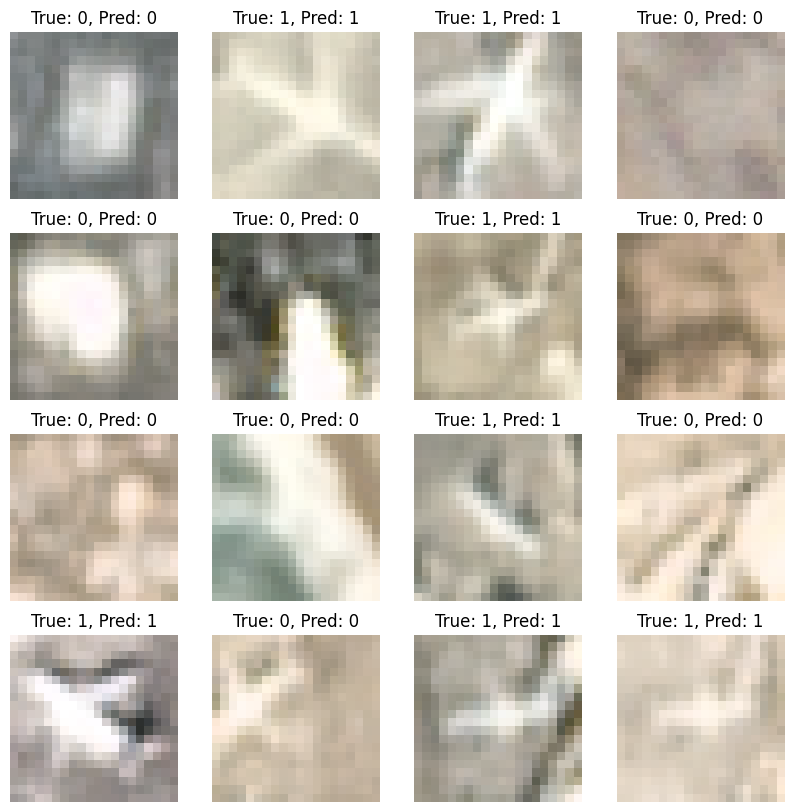

[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1]


In [ ]:
# DataLoader setup
loader = DataLoader(dataset, batch_size=1, shuffle=True)  # Batch size set to 1 for simplicity

def get_predictions(model, loader, num_images):
    images, true_labels, predictions = [], [], []
    model.eval()
    with torch.no_grad():
        for _ in range(num_images):
            img, label = next(iter(loader))
            pred = model(img)
            pred_label = pred.argmax(dim=1)
            images.append(img.cpu().squeeze(0)) # Remove batch dimension and move to CPU
            true_labels.append(label.item())
            predictions.append(pred_label.cpu().item())
    return images, true_labels, predictions

def show_images(images, true_labels, predictions):
    plt.figure(figsize=(10, 10))
    for i, (image, true_label, pred_label) in enumerate(zip(images, true_labels, predictions)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(image.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
        plt.title(f'True: {true_label}, Pred: {pred_label}')
        plt.axis('off')
    plt.show()

#show images and Predictions + True labels
images, true_labels, predictions = get_predictions(model, loader, 16)
show_images(images, true_labels, predictions)

print(predictions)

In [ ]:
#For our applications we have to test this on a "full scene image"
#Using a sliding window method to detect planes

def sliding_window(image, stepSize, windowSize):
    """ Slides a window across the image """
    for y in range(0, image.shape[0] - windowSize[1], stepSize):
        for x in range(0, image.shape[1] - windowSize[0], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

def resize_patches(patch, size=(20, 20)):
    """ Resize the patch to the input size expected by the CNN """
    return np.array(Image.fromarray(patch).resize(size, Image.ANTIALIAS))

In [ ]:
# Load full image
full_scene_image = np.array(Image.open('/content/drive/MyDrive/1.CX1 Project (1)/planesnet/scenes/scene_1.png'))

# Define different sizes for sliding windows
window_sizes = [(20, 20), (30,30),(40, 40)] #different sized planes might fit in different sized boxes
step_size = 10  # Step size for the sliding window

<ipython-input-16-cc9463370d88>:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  return np.array(Image.fromarray(patch).resize(size, Image.ANTIALIAS))


In [ ]:
#helper function to show detections in the full scene image

import matplotlib.patches as patches

def plot_detections(image, detections):
    """ Plot image with bounding boxes of detected objects """
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Draw each bounding box
    for (x, y, w, h) in detections:
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

<ipython-input-16-cc9463370d88>:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  return np.array(Image.fromarray(patch).resize(size, Image.ANTIALIAS))


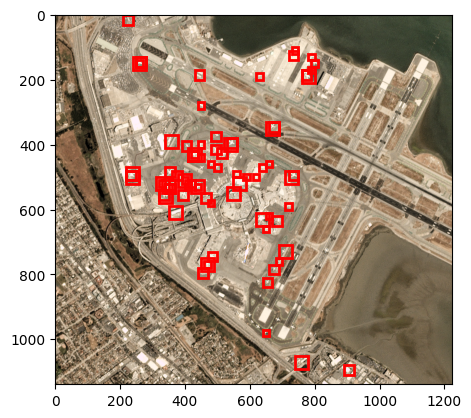

In [ ]:
#detect planes and show boxes around the

detections = []
model.eval()
with torch.no_grad():
  for window_size in window_sizes:
      for (x, y, window) in sliding_window(full_scene_image, step_size, window_size):
          if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
              continue  # Skip incomplete windows

          # Resize the window for the model to 20x20 pixels
          window = resize_patches(window)

          # Convert to tensor, add batch dimension, and normalize
          window_tensor = torch.tensor(window).float().unsqueeze(0).permute(0, 3, 1, 2) / 255.0

          # Check for plane detection
          pred = model(window_tensor)
          pred_label = pred.argmax(dim=1)
          if pred_label.cpu().item() == 1:
              # Scale back up to the original image size
              detections.append((x, y, window_size[0], window_size[1]))

#Show plot detections
plot_detections(full_scene_image, detections)

In [ ]:
!pip install pytorch-gradcam

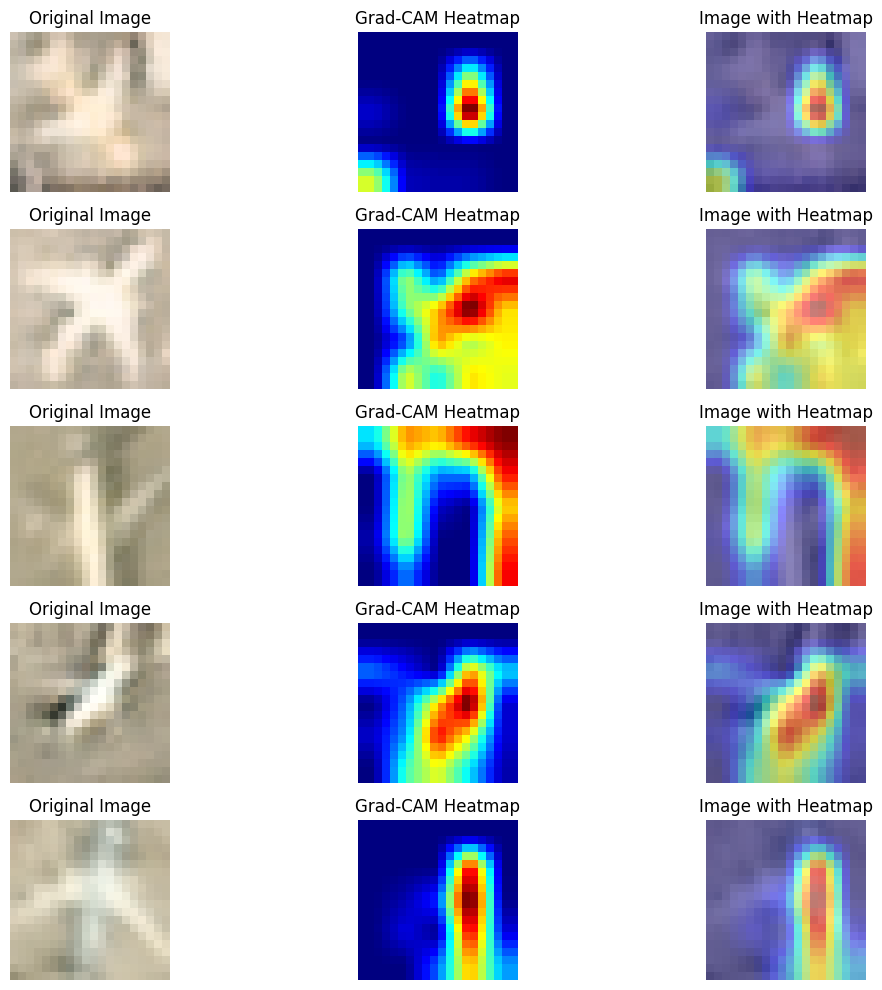

In [ ]:
#Using GradCAM to find interpretability in our model
#help from ChatCPT in creating example code

from torchvision.utils import make_grid
from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam


def apply_gradcam(model, img_tensor):
    # Ensure img_tensor has the batch dimension, expected shape [1, C, H, W]
    if img_tensor.dim() == 3:
        img_tensor = img_tensor.unsqueeze(0)  # Add a batch dimension if not present

    target_layer = model.conv_layers[-3]  # Last convolutional layer as target
    gradcam = GradCAM(model, target_layer)
    mask, _ = gradcam(img_tensor)  # Use the tensor with the batch dimension

    # Visualize heatmap
    heatmap, result = visualize_cam(mask, img_tensor.squeeze())  # Remove batch dimension for visualization

    # Convert tensor to PIL for visualization
    transform = transforms.ToPILImage()
    heatmap = transform(heatmap)
    result = transform(result)

    return heatmap, result

# Modifying how the dataset is processed
def gradcam_for_label_one(dataset, model):
    model.eval()  # Ensure model is in evaluation mode
    images = []
    for img_tensor, label in dataset:
        if label == 1:
            heatmap, result = apply_gradcam(model, img_tensor)
            images.append((img_tensor.squeeze(), heatmap, result))  # Squeeze to remove the batch dimension for plotting
            if len(images) == 5:
                break
    return images

train_images = DataLoader(train_dataset, batch_size=1, shuffle=True)  # DataLoader with batch_size=1 for individual processing

# Visualize Grad-CAM results
images = gradcam_for_label_one(train_images, model)
fig, axs = plt.subplots(len(images), 3, figsize=(12, 10))
for i, (img_tensor, heatmap, result) in enumerate(images[2]):
    axs[i, 0].imshow(transforms.ToPILImage()(img_tensor))
    axs[i, 0].title.set_text('Original Image')
    axs[i, 1].imshow(heatmap)
    axs[i, 1].title.set_text('Grad-CAM Heatmap')
    axs[i, 2].imshow(result)
    axs[i, 2].title.set_text('Image with Heatmap')
    for ax in axs[i]:
        ax.axis('off')
plt.tight_layout()
plt.show()


 OpenAI. (2023). https://www.openai.com/chatgpt

 Used throughout for pseudo-code for efficiency
